In [1]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer, IterativeImputer
from sklearn.pipeline import make_pipeline,Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils.class_weight import compute_class_weight
from sklearn.feature_extraction.text import TfidfVectorizer
import ast
from scipy.sparse import hstack
import matplotlib.pyplot as plt
import itertools

In [2]:
root = 'archive/'

In [3]:
interactions_test = pd.read_csv(f'{root}interactions_test.csv')
interactions_train = pd.read_csv(f'{root}interactions_train.csv')
interactions_validation = pd.read_csv(f'{root}interactions_validation.csv')
PP_recipes = pd.read_csv(f'{root}PP_recipes.csv').set_index('i').sort_index()
PP_users = pd.read_csv(f'{root}PP_users.csv').set_index('u').sort_index()
RAW_interactions = pd.read_csv(f'{root}RAW_interactions.csv')
RAW_recipes = pd.read_csv(f'{root}RAW_recipes.csv')

In [4]:
texts = RAW_interactions[['rating', 'review']].dropna()

grouped = texts.groupby('rating')['review'].apply(lambda x: ' '.join(x.astype(str)))
docs = grouped.tolist()
ratings = grouped.index.tolist()

vec = TfidfVectorizer(max_features=5000, ngram_range=(1,2), stop_words='english')
tfidf = vec.fit_transform(docs) # shape: (n_ratings, vocab_size)

feature_names = np.array(vec.get_feature_names_out())
top_k = 100
top_terms = {}
for i, r in enumerate(ratings):
    row = tfidf[i].toarray().ravel()
    top_idx = row.argsort()[::-1][:top_k]
    top_terms[r] = list(zip(feature_names[top_idx], row[top_idx]))

count={}
for rate in top_terms:
    for word in top_terms[rate]:
        if word[0] not in count:
            count[word[0]] = 0
        count[word[0]] += 1

for rate in top_terms:
    new_words = []
    for word in top_terms[rate]:
        if count[word[0]] < 2:
            new_words.append(word)
    top_terms[rate] = new_words

for rate in top_terms:
    print(f"{rate}: {top_terms[rate]}")

0: [('going', 0.04139197841059942), ('years', 0.035337143228219174), ('want', 0.030881139829939334), ('brown', 0.030762707845931898), ('gt', 0.030481431883914233), ('lt', 0.030437019889911446), ('food', 0.030333391903904935)]
1: [('waste', 0.04890577388472277), ('directions', 0.044060419801031606), ('awful', 0.03798757601613869), ('batter', 0.03424050219141753), ('terrible', 0.03417589747030164), ('horrible', 0.033400640816911055), ('recipe exactly', 0.03314222193244753), ('tasted like', 0.03146249918343459), ('couldn', 0.031139475577855184), ('away', 0.030041195318885185), ('got', 0.030041195318885185)]
2: [('care', 0.0423509324603239), ('just didn', 0.038790690961149864)]
3: [('needed', 0.03784435344439555), ('different', 0.03184868913426729)]
4: [('meal', 0.03122903222720964), ('really good', 0.03121043466156695)]
5: [('great recipe', 0.046305419133641466), ('excellent', 0.0433030070975857), ('keeper', 0.03618601043878886), ('day', 0.03316180889899395), ('dh', 0.02994331761752503)]


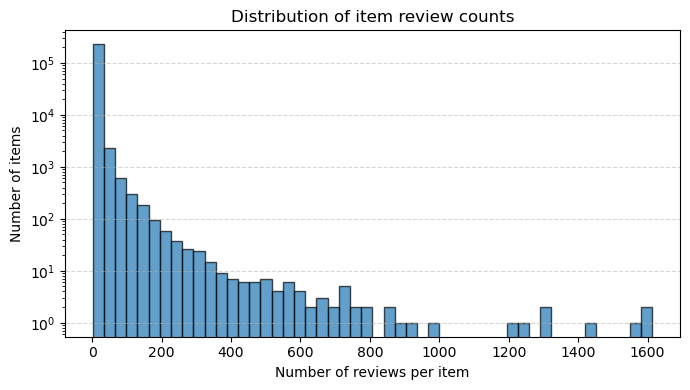

In [5]:
item_counts = RAW_interactions.groupby('recipe_id').size()

plt.figure(figsize=(7,4))
plt.hist(item_counts, bins=50, edgecolor="black", alpha=0.7)
plt.xlabel("Number of reviews per item")
plt.ylabel("Number of items")
plt.title("Distribution of item review counts")
plt.grid(axis="y", linestyle="--", alpha=0.5)
plt.yscale("log")  # optional: log-scale if the tail is heavy
plt.tight_layout()
plt.show()

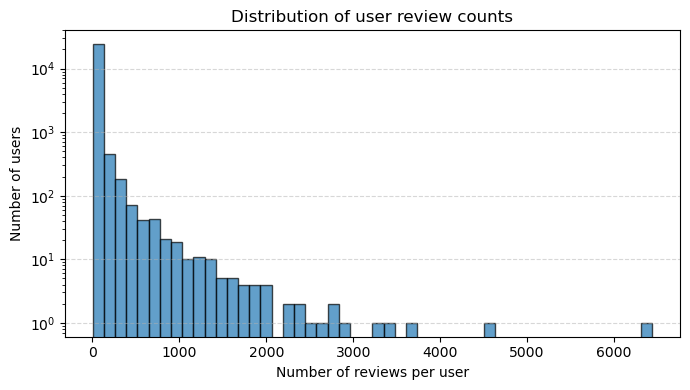

In [6]:
user_counts = PP_users['n_ratings']  # or RAW_interactions.groupby('user_id').size()

plt.figure(figsize=(7,4))
plt.hist(user_counts, bins=50, edgecolor="black", alpha=0.7)
plt.xlabel("Number of reviews per user")
plt.ylabel("Number of users")
plt.title("Distribution of user review counts")
plt.grid(axis="y", linestyle="--", alpha=0.5)
plt.yscale("log")  # optional if tail is heavy
plt.tight_layout()
plt.show()

In [7]:
recipe_review_counts = RAW_interactions.groupby('recipe_id')['rating'].count()
recipe_review_counts

recipe_id
38        4
39        1
40        9
41        2
43        1
         ..
537459    1
537485    1
537543    1
537671    1
537716    1
Name: rating, Length: 231637, dtype: int64

In [8]:
PP_recipes.dtypes

id                    int64
name_tokens          object
ingredient_tokens    object
steps_tokens         object
techniques           object
calorie_level         int64
ingredient_ids       object
dtype: object

In [9]:
PP_recipes['n_reviewers'] = PP_recipes['id'].apply(lambda x: recipe_review_counts[x])
PP_recipes['name_tokens'] = PP_recipes['name_tokens'].apply(lambda x: ast.literal_eval(x))
PP_recipes['ingredient_tokens'] = PP_recipes['ingredient_tokens'].apply(lambda x: ast.literal_eval(x))
PP_recipes['steps_tokens'] = PP_recipes['steps_tokens'].apply(lambda x: ast.literal_eval(x))
PP_recipes['techniques'] = PP_recipes['techniques'].apply(lambda x: ast.literal_eval(x))
PP_recipes['ingredient_ids'] = PP_recipes['ingredient_ids'].apply(lambda x: ast.literal_eval(x))
PP_recipes['n_steps'] = PP_recipes.merge(RAW_recipes, on='id', how='left')['n_steps']

PP_recipes

,id,name_tokens,ingredient_tokens,steps_tokens,techniques,calorie_level,ingredient_ids,n_reviewers,n_steps
i,,,,,,,,,
0,40893,"[40480, 1454, 16201, 2056, 955, 541, 11332, 82...","[[1424, 8876, 11007], [3484, 21453], [38966, 2...","[40480, 40482, 23667, 11007, 240, 21453, 240, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, ...",0,"[3384, 7979, 2127, 3502, 3217, 1257, 2778, 500...",2,4
1,44394,"[40480, 34712, 22683, 11274, 5409, 29868, 40481]","[[5343, 535, 2044, 5409, 7087], [17869, 6020],...","[40480, 40482, 12172, 1281, 5409, 7087, 240, 6...","[1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0,"[912, 7557, 2499, 5382]",1,5
2,85009,"[40480, 12187, 13995, 571, 14719, 40481]","[[1061, 494, 813, 2141], [31843], [30645, 4785...","[40480, 40482, 2572, 19472, 31757, 512, 823, 4...","[1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, ...",2,"[4623, 6265, 1168, 6016, 3597, 3440, 7213, 169...",2,3
3,134728,"[40480, 27, 12, 263, 4017, 1494, 273, 14122, 4...","[[5867, 34056], [17918], [15022, 8361], [6953]...","[40480, 40482, 7087, 17918, 240, 6953, 488, 11...","[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1,"[1304, 2683, 3217, 6270, 3532, 869, 7557, 3698...",7,10
4,200236,"[40480, 16212, 11880, 556, 19811, 12772, 22075...","[[16212, 1535], [6953], [1430, 1301, 11332], [...","[40480, 40482, 2525, 10906, 485, 29848, 40478,...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, ...",2,"[4130, 6270, 3486, 7557, 5010, 3203, 2683, 125...",4,14
...,...,...,...,...,...,...,...,...,...
178260,50804,"[40480, 5867, 3586, 17532, 14349, 29139, 40481]","[[589, 260, 4001, 17918], [6953], [15473, 1016...","[40480, 40482, 5867, 271, 715, 11868, 2525, 48...","[0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, ...",2,"[63, 6270, 335, 332, 4717, 2499, 6676, 4987, 6...",1,11
178261,492861,"[40480, 554, 13641, 2169, 40481]","[[1353], [2169], [1430, 857, 643, 1631], [1657...","[40480, 40482, 6927, 481, 11007, 271, 14259, 4...","[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0,"[7655, 1625, 3489, 7821]",2,13
178262,249924,"[40480, 7482, 8533, 9, 263, 1494, 273, 5867, 1...","[[1657, 5867], [24329, 26285], [6945, 978, 113...","[40480, 40482, 587, 616, 246, 850, 522, 867, 7...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, ...",2,"[7819, 1504, 1986, 3732, 7714]",5,9


In [10]:
PP_users['techniques'] = PP_users['techniques'].apply(lambda x: ast.literal_eval(x))
PP_users['items'] = PP_users['items'].apply(lambda x: ast.literal_eval(x))
PP_users['ratings'] = PP_users['ratings'].apply(lambda x: ast.literal_eval(x))

PP_users

,techniques,items,n_items,ratings,n_ratings
u,,,,,
0,"[8, 0, 0, 5, 6, 0, 0, 1, 0, 9, 1, 0, 0, 0, 1, ...","[1118, 27680, 32541, 137353, 16428, 28815, 658...",31,"[5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 4.0, 4.0, ...",31
1,"[11, 0, 0, 2, 12, 0, 0, 0, 0, 14, 5, 0, 0, 0, ...","[122140, 77036, 156817, 76957, 68818, 155600, ...",39,"[5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, ...",39
2,"[13, 0, 0, 7, 5, 0, 1, 2, 1, 11, 0, 1, 0, 0, 1...","[168054, 87218, 35731, 1, 20475, 9039, 124834,...",27,"[3.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 5.0, ...",27
3,"[498, 13, 4, 218, 376, 3, 2, 33, 16, 591, 10, ...","[163193, 156352, 102888, 19914, 169438, 55772,...",1513,"[5.0, 5.0, 5.0, 5.0, 4.0, 4.0, 5.0, 5.0, 5.0, ...",1513
4,"[161, 1, 1, 86, 93, 0, 0, 11, 2, 141, 0, 16, 0...","[72857, 38652, 160427, 55772, 119999, 141777, ...",376,"[5.0, 5.0, 5.0, 5.0, 4.0, 4.0, 5.0, 4.0, 5.0, ...",376
...,...,...,...,...,...
25071,"[1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, ...","[144172, 154054]",2,"[5.0, 5.0]",2
25072,"[1, 0, 0, 0, 2, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, ...","[162436, 148228]",2,"[5.0, 5.0]",2
25073,"[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[162681, 172034]",2,"[5.0, 5.0]",2


In [11]:
recipes_interactions_merged = interactions_train.merge(PP_recipes, left_on='recipe_id', right_index=True, how='left')
users_interactions_merged = interactions_train.merge(PP_users, left_on='recipe_id', right_index=True, how='left')
avg_ratings_per_recipe = recipes_interactions_merged.groupby('recipe_id')['rating'].mean()
avg_ratings_per_user = users_interactions_merged.groupby('user_id')['rating'].mean()

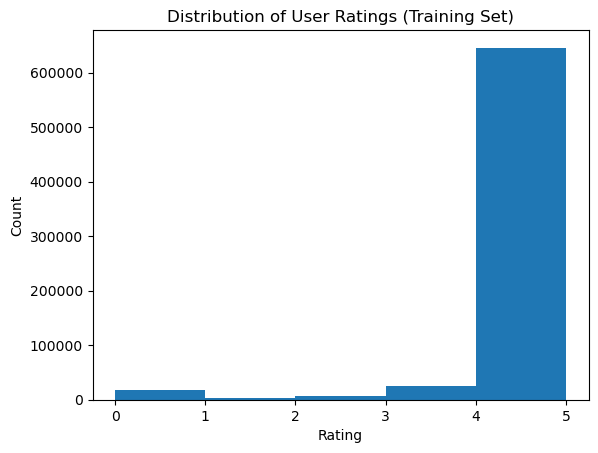

In [12]:
plt.hist(interactions_train['rating'], bins=5)
plt.xlabel('Rating')
plt.ylabel('Count')
plt.title('Distribution of User Ratings (Training Set)')
plt.show()

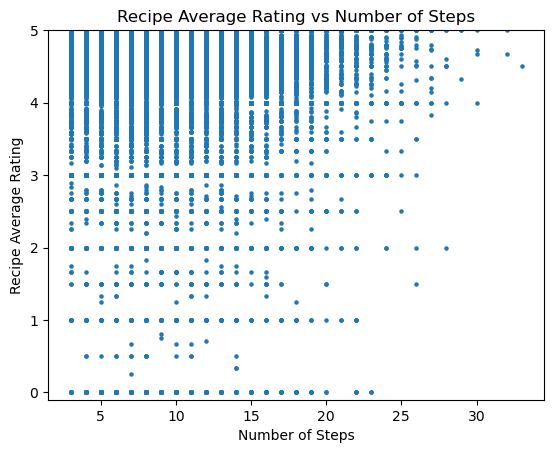

In [13]:
steps_per_recipe = recipes_interactions_merged.groupby('recipe_id')['n_steps'].first()

plt.scatter(steps_per_recipe, avg_ratings_per_recipe, s=5)
plt.xlabel('Number of Steps')
plt.ylabel('Recipe Average Rating')
plt.ylim(0,5)
plt.title('Recipe Average Rating vs Number of Steps')
plt.show()

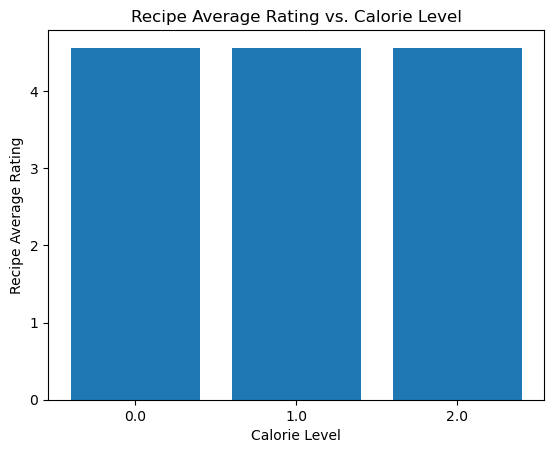

In [14]:
calorie_level_per_recipe = recipes_interactions_merged.groupby('calorie_level')['rating'].mean()

plt.bar(x=calorie_level_per_recipe.index.astype(str), height=calorie_level_per_recipe)
plt.xlabel('Calorie Level')
plt.ylabel('Recipe Average Rating')
plt.title('Recipe Average Rating vs. Calorie Level');

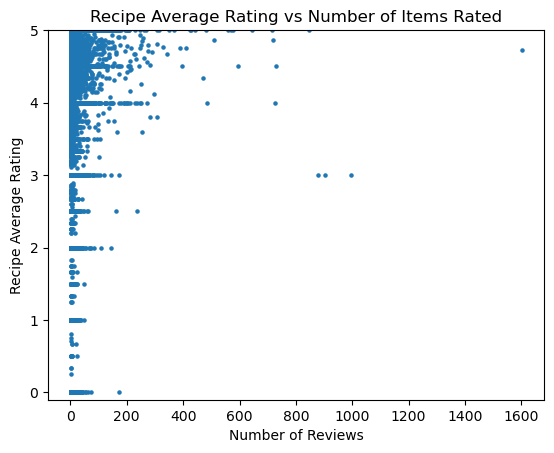

In [15]:
reviews_per_recipe = recipes_interactions_merged.groupby('recipe_id')['n_reviewers'].first()

plt.scatter(reviews_per_recipe, avg_ratings_per_recipe, s=5)
plt.xlabel('Number of Reviews')
plt.ylabel('Recipe Average Rating')
plt.ylim(0,5)
plt.title('Recipe Average Rating vs Number of Items Rated');

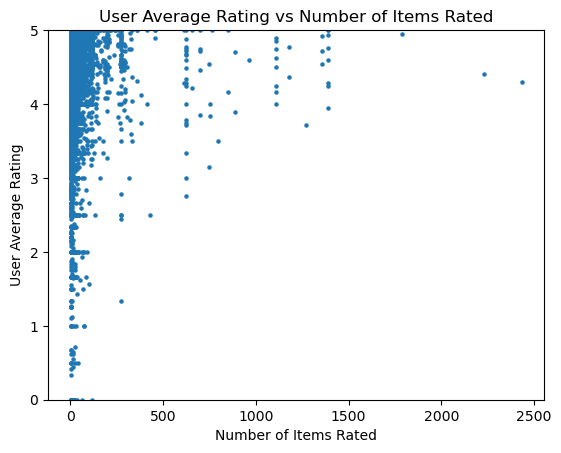

In [16]:
items_per_user = users_interactions_merged.groupby('user_id')['n_items'].first()

plt.scatter(items_per_user, avg_ratings_per_user, s=5)
plt.xlabel('Number of Items Rated')
plt.ylabel('User Average Rating')
plt.ylim(0,5)
plt.title('User Average Rating vs Number of Items Rated');

In [17]:
def Jaccard(s1, s2):
    numer = len(s1.intersection(s2))
    denom = len(s1.union(s2))
    if denom > 0:
        return numer/denom
    return 0

def MSE(predictions, y):
    diffs = [(a-b)**2 for (a,b) in zip(predictions, y)]
    return sum(diffs)/len(diffs)

def euclidean_distance(arr1, arr2):
    return np.sqrt(sum((arr1 - arr2)**2))

def normalize(arr):
    min = np.min(arr)
    max = np.max(arr)

    return (arr - min) / (max - min)

In [18]:
train_X = interactions_train.drop(columns=['rating'])
train_y = interactions_train['rating']
validation_X = interactions_validation.drop(columns=['rating'])
validation_y = interactions_validation['rating']
test_X = interactions_test.drop(columns=['rating'])
test_y = interactions_test['rating']

In [19]:
PP_recipes

,id,name_tokens,ingredient_tokens,steps_tokens,techniques,calorie_level,ingredient_ids,n_reviewers,n_steps
i,,,,,,,,,
0,40893,"[40480, 1454, 16201, 2056, 955, 541, 11332, 82...","[[1424, 8876, 11007], [3484, 21453], [38966, 2...","[40480, 40482, 23667, 11007, 240, 21453, 240, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, ...",0,"[3384, 7979, 2127, 3502, 3217, 1257, 2778, 500...",2,4
1,44394,"[40480, 34712, 22683, 11274, 5409, 29868, 40481]","[[5343, 535, 2044, 5409, 7087], [17869, 6020],...","[40480, 40482, 12172, 1281, 5409, 7087, 240, 6...","[1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0,"[912, 7557, 2499, 5382]",1,5
2,85009,"[40480, 12187, 13995, 571, 14719, 40481]","[[1061, 494, 813, 2141], [31843], [30645, 4785...","[40480, 40482, 2572, 19472, 31757, 512, 823, 4...","[1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, ...",2,"[4623, 6265, 1168, 6016, 3597, 3440, 7213, 169...",2,3
3,134728,"[40480, 27, 12, 263, 4017, 1494, 273, 14122, 4...","[[5867, 34056], [17918], [15022, 8361], [6953]...","[40480, 40482, 7087, 17918, 240, 6953, 488, 11...","[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1,"[1304, 2683, 3217, 6270, 3532, 869, 7557, 3698...",7,10
4,200236,"[40480, 16212, 11880, 556, 19811, 12772, 22075...","[[16212, 1535], [6953], [1430, 1301, 11332], [...","[40480, 40482, 2525, 10906, 485, 29848, 40478,...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, ...",2,"[4130, 6270, 3486, 7557, 5010, 3203, 2683, 125...",4,14
...,...,...,...,...,...,...,...,...,...
178260,50804,"[40480, 5867, 3586, 17532, 14349, 29139, 40481]","[[589, 260, 4001, 17918], [6953], [15473, 1016...","[40480, 40482, 5867, 271, 715, 11868, 2525, 48...","[0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, ...",2,"[63, 6270, 335, 332, 4717, 2499, 6676, 4987, 6...",1,11
178261,492861,"[40480, 554, 13641, 2169, 40481]","[[1353], [2169], [1430, 857, 643, 1631], [1657...","[40480, 40482, 6927, 481, 11007, 271, 14259, 4...","[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0,"[7655, 1625, 3489, 7821]",2,13
178262,249924,"[40480, 7482, 8533, 9, 263, 1494, 273, 5867, 1...","[[1657, 5867], [24329, 26285], [6945, 978, 113...","[40480, 40482, 587, 616, 246, 850, 522, 867, 7...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, ...",2,"[7819, 1504, 1986, 3732, 7714]",5,9


In [20]:
PP_users

,techniques,items,n_items,ratings,n_ratings
u,,,,,
0,"[8, 0, 0, 5, 6, 0, 0, 1, 0, 9, 1, 0, 0, 0, 1, ...","[1118, 27680, 32541, 137353, 16428, 28815, 658...",31,"[5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 4.0, 4.0, ...",31
1,"[11, 0, 0, 2, 12, 0, 0, 0, 0, 14, 5, 0, 0, 0, ...","[122140, 77036, 156817, 76957, 68818, 155600, ...",39,"[5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, ...",39
2,"[13, 0, 0, 7, 5, 0, 1, 2, 1, 11, 0, 1, 0, 0, 1...","[168054, 87218, 35731, 1, 20475, 9039, 124834,...",27,"[3.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 5.0, ...",27
3,"[498, 13, 4, 218, 376, 3, 2, 33, 16, 591, 10, ...","[163193, 156352, 102888, 19914, 169438, 55772,...",1513,"[5.0, 5.0, 5.0, 5.0, 4.0, 4.0, 5.0, 5.0, 5.0, ...",1513
4,"[161, 1, 1, 86, 93, 0, 0, 11, 2, 141, 0, 16, 0...","[72857, 38652, 160427, 55772, 119999, 141777, ...",376,"[5.0, 5.0, 5.0, 5.0, 4.0, 4.0, 5.0, 4.0, 5.0, ...",376
...,...,...,...,...,...
25071,"[1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, ...","[144172, 154054]",2,"[5.0, 5.0]",2
25072,"[1, 0, 0, 0, 2, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, ...","[162436, 148228]",2,"[5.0, 5.0]",2
25073,"[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[162681, 172034]",2,"[5.0, 5.0]",2


In [21]:
# Baseline 1: Always Predict Global Average

global_average = interactions_train['rating'].mean()
print('Mean Squared Error for Baseline 1 (Always Predict Global Average):', MSE([global_average] * test_y.shape[0], test_y))

# Baseline 2: Regresssion With Two Predictors

baseline_train_X_features = [[PP_recipes.iloc[i]['calorie_level'], PP_users.iloc[u]['n_items']] for u, i in train_X[['u', 'i']].to_numpy()]
baseline_test_X_features = [[PP_recipes.iloc[i]['calorie_level'], PP_users.iloc[u]['n_items']] for u, i in test_X[['u', 'i']].to_numpy()]

baseline_model = LinearRegression()
baseline_model.fit(baseline_train_X_features, train_y)
baseline_model_preds = baseline_model.predict(baseline_test_X_features)
print('Mean Squared Error for Baseline 2 (Regrission With Two Predictors):', MSE(baseline_model_preds, test_y))

Mean Squared Error for Baseline 1 (Always Predict Global Average): 1.921769558034767
Mean Squared Error for Baseline 2 (Regrission With Two Predictors): 1.889391224000366


In [22]:
user_stats = interactions_train.groupby('u')['rating'].agg(['mean', 'count'])
item_stats = interactions_train.groupby('i')['rating'].agg(['mean', 'count'])
reg = 10  # shrinkage to avoid huge biases for low counts

user_bias = ((user_stats['mean'] - global_average) * user_stats['count'] / (user_stats['count'] + reg)).to_dict()
item_bias = ((item_stats['mean'] - global_average) * item_stats['count'] / (item_stats['count'] + reg)).to_dict()

recipe_sets = {
    'ingredient_ids': [set(x) for x in PP_recipes['ingredient_ids']],
    'steps_tokens':   [set(x) for x in PP_recipes['steps_tokens']],
}

max_date = pd.to_datetime(interactions_train['date']).max()
user_avg_calorie = {
    u: float(np.mean([PP_recipes.iloc[i]['calorie_level'] for i in items])) if len(items) else 0.0
    for u, items in zip(PP_users.index, PP_users['items'])
}
user_avg_steps = {
    u: float(np.mean([PP_recipes.iloc[i]['n_steps'] for i in items])) if len(items) else 0.0
    for u, items in zip(PP_users.index, PP_users['items'])
}

user_log_n = np.log1p(PP_users['n_ratings'])
recipe_log_n = np.log1p(PP_recipes['n_reviewers'])

user_bins = pd.qcut(user_log_n, q=5, labels=False, duplicates="drop")  # 0..4
recipe_bins = pd.qcut(recipe_log_n, q=5, labels=False, duplicates="drop")

PP_users['logn_bin'] = user_bins
PP_recipes['logn_bin'] = recipe_bins

user_items = PP_users['items']  # alias
TOP_K = 5
K_CAP = 30
rng = np.random.default_rng(42)


In [23]:
def one_hot_bin(bin_val, n_bins=5):
    arr = np.zeros(n_bins, dtype=float)
    if bin_val == bin_val:  # not NaN
        arr[int(bin_val)] = 1.0
    return arr

In [24]:
def familiarity_simple(datum, col, use_max=False):
    u = datum['u']
    r = datum['i']
    target = recipe_sets[col][r]
    items = user_items.iloc[u]
    if len(items) > K_CAP:
        items = rng.choice(items, size=K_CAP, replace=False)
    sims = []
    for rid in items:
        known = recipe_sets[col][rid]
        inter = len(target & known)
        union = len(target) + len(known) - inter
        sims.append(inter / union if union else 0.0)
    if not sims:
        return 0.0
    sims = sorted(sims, reverse=True)[:TOP_K]
    return max(sims) if use_max else float(np.mean(sims))


In [25]:
def familiarity(datum, col):
    u = datum['u']
    r = datum['i']
    target = recipe_sets[col][r]
    items = user_items.iloc[u]
    if len(items) > K:
        items = np.random.default_rng(0).choice(items, size=K, replace=False)
    sims = []
    for rid in items:
        known = recipe_sets[col][rid]
        inter = len(target & known)
        union = len(target) + len(known) - inter
        sims.append(inter / union if union else 0.0)
    return float(np.mean(sims)) if len(sims) else 0.0


In [26]:
def safe_mean(vals):
    return float(np.mean(vals)) if len(vals) else 0.0

In [27]:
def feature(datum):
    u = datum['u']
    r = datum['i']
    ub = user_bias.get(u, 0.0)
    ib = item_bias.get(r, 0.0)
    calorie_level = PP_recipes.iloc[r]['calorie_level']
    n_steps = PP_recipes.iloc[r]['n_steps']
    cal_delta = calorie_level - user_avg_calorie.get(u, 0.0)
    steps_delta = n_steps - user_avg_steps.get(u, 0.0)
    recency_days = (max_date - pd.to_datetime(datum['date'])).days
    ingredient_fam = familiarity_simple(datum, 'ingredient_ids')
    steps_fam = familiarity_simple(datum, 'steps_tokens')
    recipe_tech = np.array(PP_recipes.iloc[r]['techniques'])
    denom = recipe_tech.sum()
    technique_overlap = ((np.array(PP_users.iloc[u]['techniques']) * recipe_tech).sum() / denom) if denom else 0.0
    user_bin_oh = one_hot_bin(PP_users.iloc[u]['logn_bin'])
    recipe_bin_oh = one_hot_bin(PP_recipes.iloc[r]['logn_bin'])
    return [
        ub, ib,
        calorie_level, n_steps,
        cal_delta, steps_delta,
        recency_days,
        ingredient_fam, steps_fam,
        technique_overlap,
        *user_bin_oh,
        *recipe_bin_oh,
    ]

In [28]:
#TF-IDF
texts = RAW_interactions[['rating', 'review']].dropna()
grouped = texts.groupby('rating')['review'].apply(lambda x: ' '.join(x.astype(str)))
docs = grouped.tolist()
ratings = grouped.index.tolist()

vec = TfidfVectorizer(max_features=5000, ngram_range=(1,2), stop_words='english')
tfidf = vec.fit_transform(docs)
vocab = np.array(vec.get_feature_names_out())

def remove_tfidf_outliers(mat, whisker=1.5):
    arr = mat.toarray()
    for i in range(arr.shape[0]):
        row = arr[i]
        nz = row[row > 0]
        if nz.size == 0:
            continue
        q1, q3 = np.percentile(nz, [25, 75])
        cutoff = q3 + whisker * (q3 - q1)
        row[row > cutoff] = 0.0
        arr[i] = row
    return arr

tfidf_clean = remove_tfidf_outliers(tfidf, whisker=1.5)

# build unique top-k vocab per rating
top_k = 10
term_counts = {}
top_terms = {}
for i, r in enumerate(ratings):
    row = tfidf_clean[i]
    idx = row.argsort()[::-1][:top_k * 3]  # grab extra in case of overlaps
    terms = [(vocab[j], row[j]) for j in idx if row[j] > 0]
    top_terms[r] = terms
    for t, _ in terms:
        term_counts[t] = term_counts.get(t, 0) + 1

clean_vocab_terms = []
for r, terms in top_terms.items():
    picked = []
    for t, s in terms:
        if term_counts[t] == 1:
            picked.append((t, s))
        if len(picked) == top_k:
            break
    clean_vocab_terms.extend([t for t, _ in picked])

clean_vocab = {t: i for i, t in enumerate(sorted(set(clean_vocab_terms)))}

In [29]:
len(train_X), len(validation_X), len(test_X)

(698901, 7023, 12455)

In [30]:
# add review text to splits by user_id/recipe_id
key_cols = ["user_id", "recipe_id"]

raw_reviews = RAW_interactions[key_cols + ["review"]]

interactions_train = interactions_train.merge(raw_reviews, on=key_cols, how="left")
interactions_validation = interactions_validation.merge(raw_reviews, on=key_cols, how="left")
interactions_test = interactions_test.merge(raw_reviews, on=key_cols, how="left")

# keep only training items with at least two reviews
item_counts = interactions_train.groupby('recipe_id').size()
keep_items = item_counts[item_counts >= 2].index
interactions_train = interactions_train[interactions_train['recipe_id'].isin(keep_items)].reset_index(drop=True)
train_X = interactions_train.drop(columns=['rating'])
train_y = interactions_train['rating']

In [31]:
# Build numerical features
numeric_train = np.vstack(train_X.apply(feature, axis=1))
numeric_val   = np.vstack(validation_X.apply(feature, axis=1))
numeric_test  = np.vstack(test_X.apply(feature, axis=1))

In [32]:
#Build vocab feature
vec_clean = TfidfVectorizer(vocabulary=clean_vocab)
tfidf_train = vec_clean.fit_transform(interactions_train['review'].fillna(''))
tfidf_val   = vec_clean.transform(interactions_validation['review'].fillna(''))
tfidf_test  = vec_clean.transform(interactions_test['review'].fillna(''))

In [33]:
# combine numeric + tfidf (sparse)
train_features = hstack([numeric_train, tfidf_train])
val_features   = hstack([numeric_val, tfidf_val])
test_features  = hstack([numeric_test, tfidf_test])

In [34]:
#Linear Model
lin_model = LinearRegression()
lin_model.fit(train_features, train_y)
val_preds = lin_model.predict(val_features)
test_preds = lin_model.predict(test_features)
print("Val MSE:", MSE(val_preds, validation_y))
print("Test MSE:", MSE(test_preds, test_y))

Val MSE: 1.556717789285402
Test MSE: 1.6646677089302853


In [35]:
rating_freq = interactions_train['rating'].value_counts()
inv_freq = 1.0 / rating_freq
sample_weight = interactions_train['rating'].map(inv_freq).to_numpy()

In [36]:
train_features = train_features.tocsr()
val_features   = val_features.tocsr()
test_features  = test_features.tocsr()

In [37]:
rid_model = Ridge(alpha=0.00000000001)
rid_model.fit(train_features, train_y)
val_preds = rid_model.predict(val_features)
test_preds = rid_model.predict(test_features)
print("Val MSE:", MSE(val_preds, validation_y))
print("Test MSE:", MSE(test_preds, test_y))

Val MSE: 1.5702544118455735
Test MSE: 1.6801443991689515


In [38]:
#Ridge Model
alpha_vals = [0.00000000001, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000000000]

best_mse = np.inf
best_model = best_alpha = best_combo = None

for a in alpha_vals:
        ridge = Ridge(alpha = a)
        ridge.fit(train_features, train_y)
        val_preds = ridge.predict(val_features)
        curr_mse = MSE(val_preds, validation_y)
        print(f"Validation MSE (Alpha={a}): {curr_mse}")
        if curr_mse < best_mse:
            best_mse = curr_mse
            best_model = ridge
            best_alpha = a

print("Best Alpha Value:", best_alpha)

best_model.fit(train_features, train_y)
test_preds = best_model.predict(test_features)
print("Test MSE:", MSE(test_preds, test_y))

Validation MSE (Alpha=0.0001, Combo=[0]): 3.70626606104773
Validation MSE (Alpha=0.0001, Combo=[1]): 3.2888633064136483
Validation MSE (Alpha=0.0001, Combo=[2]): 4.704452689272524
Validation MSE (Alpha=0.0001, Combo=[3]): 4.705862474683841
Validation MSE (Alpha=0.0001, Combo=[4]): 4.695637188674551
Validation MSE (Alpha=0.0001, Combo=[5]): 4.694646298353181
Validation MSE (Alpha=0.0001, Combo=[0, 1]): 2.740757392415703
Validation MSE (Alpha=0.0001, Combo=[0, 2]): 3.709206151056869
Validation MSE (Alpha=0.0001, Combo=[0, 3]): 3.7112419498469142
Validation MSE (Alpha=0.0001, Combo=[0, 4]): 3.703815503086485
Validation MSE (Alpha=0.0001, Combo=[0, 5]): 3.703100225425798
Validation MSE (Alpha=0.0001, Combo=[1, 2]): 3.2931497846955176
Validation MSE (Alpha=0.0001, Combo=[1, 3]): 3.309219825199695
Validation MSE (Alpha=0.0001, Combo=[1, 4]): 3.286181784233172
Validation MSE (Alpha=0.0001, Combo=[1, 5]): 3.2959223852288764
Validation MSE (Alpha=0.0001, Combo=[2, 3]): 4.709072613931206
Validat